### GDP and Gov Exo: Predictive Analysis

Author: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>
Date created: November 25, 2020


Citations: <br>

   - GDP data (nominal value, national currency): 
    https://data.imf.org/?sk=4c514d48-b6ba-49ed-8ab9-52b0c1a0179b&sId=1409151240976
   
   - GDP components data (nominal value, current prices, non-seasonally adjusted, national currency)
   https://data.imf.org/regular.aspx?key=61545852
   
   - US GDP for 2020Q2 imputed from here: 
   https://www.bea.gov/news/2020/gross-domestic-product-third-estimate-corporate-profits-revised-and-gdp-industry-third

#### Step 1: Import packages

In [1]:
# standard
import pandas as pd
import numpy as np
import os

# analysis
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import patsy

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Step 2: Define working directories

In [2]:
# in dirs
in_gdp_w2020 = '/Users/cilin/Dropbox/GPL_CDC_covid/data/reg/gdp/w_2020_data/'

# out dirs
out_dir = '/Users/cilin/Dropbox/GPL_CDC_covid/results/reg/gdp/'

#### Step 3: Define functions

``read data``

In [3]:
def read_gdp_w2020():
    '''
    '''
    return pd.read_csv(in_gdp_w2020 + 'gdp_reg_data.csv')

``predictions``

In [4]:
def predictions(df):
    '''
    '''
    df_predict = concat_model_fit(df)
    
    # clean
    df_predict.sort_values(by=['country', 'year', 'quarter', 'pred_scenario'], inplace=True)
    df_predict.drop(columns=['year', 'quarter'], inplace=True)
    
    return df_predict

In [5]:
def concat_model_fit(df):
    '''
    '''
    models = ['policy only (policy sample)',
              'policy, cases and mobility (mobility sample)']

    results_df = pd.DataFrame()
    
    for model in models:
        if model=='policy only (policy sample)':
            # run a model only with policy controls (df cleaned based on policy data)
            temp_df = df
            # fit the model
            temp_results = model_fit(temp_df, vars_type='policy')
            temp_results['model'] = model
            # append to results_df
            results_df = pd.concat([results_df, temp_results], axis=0)
            continue
            

        if model=='policy, cases and mobility (mobility sample)':
            # run a model with policy and mobility controls (df cleaned based on mobility data)
            temp_df = df[df.no_mob_data==0]
            # fit the model
            temp_results = model_fit(temp_df, vars_type='policy, cases and mobility')
            temp_results['model'] = model
            # append to results_df
            results_df = pd.concat([results_df, temp_results], axis=0)
    
    return results_df

In [6]:
def model_fit(df, vars_type):
    '''
    params:
    ------
    df: df with GDP and Gov Exp data + policies + mobility
    vars_type: str, indicate if the model should have only policy variables, or policy and mobility vars
    scenario: str, indicates if predictions should have no controls or controls (policy and/or mobility vars)
    outcome: str, GDP or Gov Exp
    
    
    return:
    ------
    df with prediction results
    '''
    df.reset_index(drop=True, inplace=True)
    
    # build the Y, X np.arrays
    Y, X_p, X_np = model_vars(df, vars_type)
    X = [X_p, X_np]

    # fit the model
    model = sm.OLS(Y, X_p).fit(cov_type ='cluster', cov_kwds={'groups':df['country']}) 
    #print(model.summary())
    
    # predictions #
    ################
    outcome = 'GDP_2020USD'
    new_col = 'pred_GDP_2020USD'
    
    df_predict = pd.DataFrame()

    for idx, val in enumerate(['policy', 'no policy']):
        temp_df = df

        # find y_hat
        prediction = model.get_prediction(X[idx]).summary_frame()
        #temp_df = pd.concat([temp_df, prediction[['mean', 'mean_ci_lower', 'mean_ci_upper']]], axis=1)
        temp_df = pd.concat([temp_df, prediction[['mean']]], axis=1)
        temp_df.rename(columns={'mean':'pred_l_GDP_2020USD'}, inplace=True)
        
        ##############################################################
        # Apply correction as in (see source bellow)
        #https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/
        
        # get RMSE
        Ypred = pd.DataFrame(temp_df['pred_l_GDP_2020USD'])
        RMSE = rmse(Y, Ypred)
        print(RMSE)
        
        # exponentiate
        temp_df[new_col] = np.exp(temp_df['pred_l_GDP_2020USD']) 
    
        # multiply by square of RMSE and divide by 2
        temp_df[new_col] = temp_df[new_col] * np.exp((RMSE * RMSE)/2)
        ################################################################
            
        # compute pct error
        temp_df['pct_error'] = ((temp_df[new_col] - temp_df[outcome])/temp_df[outcome])*100
    
        # add column to specify model
        temp_df['pred_scenario'] = val
        
        
        # concatenate no controls and controls results
        df_predict = pd.concat([df_predict, temp_df], axis=0)
        
        # keep only vars of interest
        #columns = ['who_region', 'iso2', 'country', 'year', 'quarter', 'year_quarter',
        #           outcome, new_col, new_col+'_ci0', new_col+'_ci1', 'pred_scenario', 'pct_error']
        columns = ['iso2', 'country', 'year', 'quarter', 'year_quarter',
                   outcome, new_col, 'l_GDP_2020USD', 'pred_l_GDP_2020USD', 'pred_scenario', 'pct_error']
    
    return df_predict[columns]

In [7]:
def model_vars(df, vars_type):
    '''
    '''
    df.reset_index(drop=True, inplace=True)
    
    # create FE and interactions between FE and continous vars
    f = 'l_GDP_2020USD ~ iso2 + quarter + year_trend * C(iso2_quarter)'
    Y, X_fe = patsy.dmatrices(f, df, return_type='dataframe')
    
    # create policies
    policies = ('p_acadclose_sch_mand_on', 
                'p_acadclose_uni_mand_on',
                'p_massgath_lt10_mand_on',
                'p_massgath_gt10_mand_on',
                'p_moverest_curf_mand_on', 
                'p_moverest_stayh_mand_on', 
                'p_moverest_stayh_mand_off',
                'p_moverest_trnsp_mand_on',
                'p_offclose_ent_mand_on', 
                'p_offclose_neb_mand_on', 
                'p_passscrn_entry_mand_on',
                'p_ppe_mask_mand_on', 
                'p_reliclos_powp_mand_on',
                'p_travrest_grp_mand_on')
        

    on_off_policies = list(np.sort([col for col in df.columns if col.startswith(policies)]))
    cases = ['new_cases_per100k']
    mobility = ['mob_residential']
    
    if vars_type == 'policy':
        X_vars = on_off_policies
        
        # policy model
        X_p = pd.concat([df[X_vars], X_fe], axis=1)
        
        # no policy model
        temp_X = pd.DataFrame(np.zeros((df[X_vars].shape[0], df[X_vars].shape[1]))) # create empty policy data
        temp_X.columns = X_vars # rename columns
        X_np = pd.concat([temp_X, X_fe], axis=1)
        
    if vars_type == 'policy, cases and mobility':
        X_vars = on_off_policies + cases + mobility
        
        # policy model
        X_p = pd.concat([df[X_vars], X_fe], axis=1)
        
        # no policy model
        temp_X = pd.DataFrame(np.zeros((df[X_vars].shape[0], df[X_vars].shape[1]))) # create empty policy data
        temp_X.columns = X_vars # rename columns
        X_np = pd.concat([temp_X, X_fe], axis=1)
    
    
    return Y, X_p, X_np

``plots``

In [8]:
def pred_actual_plot(df, model, region, plot_type):
    '''
    '''
    
    ## organize data for graph purposes ##
    ######################################
    outcome = 'GDP_2020USD'
    predicted = 'pred_GDP_2020USD'
    
    # mean plots
    returns = 'mean'
    df_mean = helper_pred_plot(df, model, region, returns)
    print(df_mean[predicted].mean())
    returns = 'all'
    df_all = helper_pred_plot(df, model, region, returns)
    
    # transform to billions
    df_mean[predicted] = df_mean[predicted]/1000
    df_all[predicted] = df_all[predicted]/1000
    print(df_mean[predicted].mean())
    
    # initialize new figure
    sns.set(rc={})
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1})
    
    # set colors
    colors = ['orangered', 'navy', 'black']
    
    # plot mean
    ax = sns.catplot(x='year_quarter', y=predicted, hue='pred_scenario', data=df_mean, 
                     kind=plot_type, legend=False, palette=sns.color_palette(colors), s=5,
                     markers=["d", "s", 'v'], 
                     linestyles = ['-.', '--', '-'])
    
    # plot bars
    '''
    for country in df_all.country.unique():
        #if country in ['France', 'Germany', 'Nethelands', 'Romania']:
            df_all_temp = df_all[(df_all.pred_scenario== 'no policy (pred)') & (df_all.country==country)]
            for c_mean, c0, c1, yq in zip(df_all_temp['pred_'+outcome],
                                          df_all_temp['pred_'+outcome+'_ci0'], df_all_temp['pred_'+outcome+'_ci1'], 
                                  range(len(df_all_temp.year_quarter.unique()))):
                plt.plot((yq, yq), (c0, c1), color='lightcoral')
                plt.scatter((yq), (c_mean), color='lightcoral', s=2)
            
    for country in df_all.country.unique():
        #if country in ['France', 'Germany', 'Romania']:
            df_all_temp = df_all[(df_all.pred_scenario== 'policy (pred)') & (df_all.country==country)]
            for c_mean, c0, c1, yq in zip(df_all_temp['pred_'+outcome],
                                          df_all_temp['pred_'+outcome+'_ci0'], df_all_temp['pred_'+outcome+'_ci1'], 
                                  range(len(df_all_temp.year_quarter.unique()))):
                plt.plot((yq, yq), (c0, c1), color='blue')
                plt.scatter((yq), (c_mean), color='blue', s=2)
    '''                 
    
    # set figure size
    ax.fig.set_figwidth(12)
    ax.fig.set_figheight(4)
    #ax.fig.set_figwidth(14)
    #ax.fig.set_figheight(5)

    # set title, axes
    plt.title('Average ' + region + ' predictions\n' + 'controls: ' + model, fontsize = 14)
    
    for ax in ax.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        for i,l in enumerate(labels):
            if i in np.arange(0,365, 1):
                labels[i] = l
            else:
                labels[i] = ''
        ax.set_xticklabels(labels, rotation=60) # set new labels
    
    plt.ylabel('GDP (2020USD, billions)')
    plt.xlabel('Year-Quarter')
    plt.legend(loc='upper left')
    
    #plt.ylim(9.8, 11)
    #plt.ylim(10, 10.8)
    #plt.ylim(10, 11.2)
    #plt.ylim(150, 300)

In [9]:
def helper_pred_plot(df, model, region, returning):
    '''
    '''
    outcome = 'GDP_2020USD'
    predicted = 'pred_GDP_2020USD'
    
    # keep only the model of interest
    if region == 'World':
        df = df[df.model==model]
    else:
        df = df[(df.model==model) & (df.who_region==region)]
    
    
    ## create 3 types of models: 
    ## no controls (predicted), controls(predicted), controls (observed) ##
    #######################################################################
    columns1 = ['iso2', 'country', 'year_quarter', predicted, 'pred_scenario']
    columns2 = ['iso2', 'country', 'year_quarter', outcome, 'pred_scenario']

    # no controls (predicted)
    no_controls = df[df.pred_scenario=='no policy']
    no_controls = no_controls[columns1]
    no_controls['pred_scenario'] = 'no policy (pred)'

    # controls (predicted)
    controls = df[df.pred_scenario=='policy']
    controls = controls[columns1]
    controls['pred_scenario'] = 'policy (pred)'

    # controls (actual)
    actual = df[df.pred_scenario=='policy']
    actual = actual[columns2]
    actual['pred_scenario'] = 'policy (actual)'
    actual.rename(columns={outcome: predicted}, inplace=True) #this is just to concatenate the data together but it's the actual GDP not the predicted one

    df = pd.concat([no_controls, controls, actual], axis=0)
    df.sort_values(by=['year_quarter', 'pred_scenario'], inplace=True)

    ## report mean cases by day (mean across countries)##
    #####################################################
    df_mean = df.groupby(['year_quarter', 'pred_scenario'], as_index=False)[predicted].sum()  
    #df_mean = df.groupby(['year_quarter', 'pred_scenario'], as_index=False)[predicted].mean()
    df_mean.sort_values(by=['year_quarter', 'pred_scenario'], inplace=True)

    # rearange by type of pred_scenario
    df_mean = pd.concat([df_mean[df_mean.pred_scenario=='no policy (pred)'],
                        df_mean[df_mean.pred_scenario=='policy (pred)'],
                        df_mean[df_mean.pred_scenario=='policy (actual)']], axis=0)

    df_mean.reset_index(drop=True, inplace=True)
    
        
    if returning=='mean':
        return df_mean
    
    if returning=='all':
        return df


#### Step 4: Read data

In [10]:
df = read_gdp_w2020()
df.head(2)

,Unnamed: 0,who_region,country,iso2,year_quarter,nat_pop,new_cases_imputed,mob_residential,who_region_y,GDP,...,p_travquar_rec_mand_off_popwt_qwt,p_travrest_airprt_mand_off_popwt_qwt,p_travrest_airprt_rec_mand_off_popwt_qwt,p_travrest_flght_mand_off_popwt_qwt,p_travrest_flght_rec_mand_off_popwt_qwt,p_travrest_tradv_mand_off_popwt_qwt,p_travrest_tradv_rec_mand_off_popwt_qwt,p_travrest_trban_mand_off_popwt_qwt,p_travrest_trban_rec_mand_off_popwt_qwt,p_travrest_grp_mand_on_popwt_qwt
0,0,EURO,Albania,AL,2014Q1,0.0,0.0,0.0,EURO,315138.273418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,EURO,Albania,AL,2014Q2,0.0,0.0,0.0,EURO,370523.883299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Step 5: Predictions

In [11]:
df_predict = predictions(df)
df_predict.head(2)

[0.01960041]
[0.04007696]
[0.01932292]
[0.03947991]


,iso2,country,year_quarter,GDP_2020USD,pred_GDP_2020USD,l_GDP_2020USD,pred_l_GDP_2020USD,pred_scenario,pct_error,model
0,AL,Albania,2014Q1,2836.244461,2806.298509,7.950236,7.938819,no policy,-1.055831,policy only (policy sample)
0,AL,Albania,2014Q1,2836.244461,2804.584403,7.950236,7.938819,policy,-1.116267,policy only (policy sample)


#### Step 6: Plots

12263118.807693912
12263.11880769391


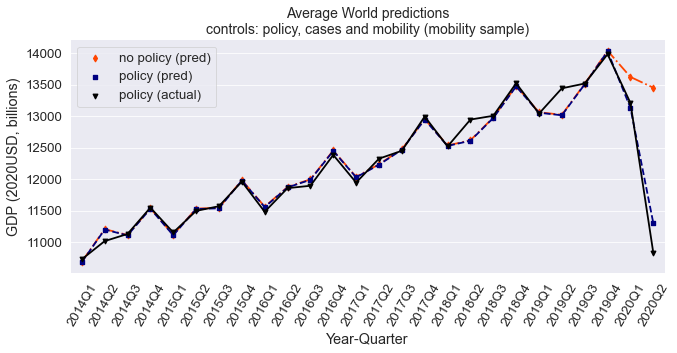

In [12]:
pred_actual_plot(df_predict, 
                 model='policy, cases and mobility (mobility sample)',
                 region='World', plot_type='point')

12283222.228381274
12283.222228381268


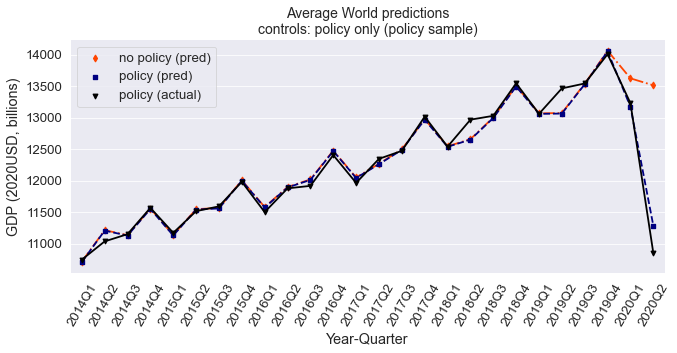

In [13]:
pred_actual_plot(df_predict, 
                 model='policy only (policy sample)',
                 region='World', plot_type='point')

--------

#### Find total GDP in 2019

In [14]:
# keep only policy, cases and mobility sample
temp = df_predict[df_predict.model=='policy only (policy sample)']

# keep pred_scenario as 'policy'
temp = temp[temp.pred_scenario=='no policy']

# keep only 2020Q1 and Q2
temp = temp[temp.year_quarter.isin(('2019Q1', '2019Q2', '2019Q3', '2019Q4'))]

# look at GDP
temp.GDP_2020USD.sum()

54080803.88685786

#### Find lost GDP in 2020 Q1 and Q2

```policy, cases, mobility sample```

In [15]:
temp = helper_pred_plot(df_predict, model='policy, cases and mobility (mobility sample)', region='World', returning='mean')
temp.sort_values(by=['year_quarter', 'pred_scenario'], inplace=True)
temp = temp[temp.year_quarter.isin(('2020Q1', '2020Q2'))]
temp.reset_index(drop=True, inplace=True)
temp.head(30)

,year_quarter,pred_scenario,pred_GDP_2020USD
0,2020Q1,no policy (pred),1.362431e+07
1,2020Q1,policy (actual),1.321150e+07
2,2020Q1,policy (pred),1.313289e+07
3,2020Q2,no policy (pred),1.345385e+07
4,2020Q2,policy (actual),1.083183e+07
5,2020Q2,policy (pred),1.130331e+07


In [16]:
# compute difference between no_policy(predicted) and policy(pred) GDP

temp = pd.DataFrame([temp.pred_GDP_2020USD[0] - temp.pred_GDP_2020USD[2],
              temp.pred_GDP_2020USD[3] - temp.pred_GDP_2020USD[5]]).T

temp.rename(columns={0:'2020Q1', 1:'2020Q2'}, inplace=True)
temp['2020Q1'] = temp['2020Q1'].astype(int)
temp['2020Q2'] = temp['2020Q2'].astype(int)
temp.rename(index={0:'policy, cases and mobility (mobility sample)'}, inplace=True)

temp.head()

,2020Q1,2020Q2
"policy, cases and mobility (mobility sample)",491420,2150543


```policy only sample```

In [17]:
temp1 = helper_pred_plot(df_predict, model='policy only (policy sample)', region='World', returning='mean')
temp1.sort_values(by=['year_quarter', 'pred_scenario'], inplace=True)
temp1 = temp1[temp1.year_quarter.isin(('2020Q1', '2020Q2'))]
temp1.reset_index(drop=True, inplace=True)
temp1.head(30)

,year_quarter,pred_scenario,pred_GDP_2020USD
0,2020Q1,no policy (pred),1.362559e+07
1,2020Q1,policy (actual),1.323105e+07
2,2020Q1,policy (pred),1.317432e+07
3,2020Q2,no policy (pred),1.351509e+07
4,2020Q2,policy (actual),1.085134e+07
5,2020Q2,policy (pred),1.128507e+07


In [18]:
# compute difference between no_policy(predicted) and policy(pred) GDP

temp1 = pd.DataFrame([temp1.pred_GDP_2020USD[0] - temp1.pred_GDP_2020USD[2],
              temp1.pred_GDP_2020USD[3] - temp1.pred_GDP_2020USD[5]]).T

temp1.rename(columns={0:'2020Q1', 1:'2020Q2'}, inplace=True)
temp1['2020Q1'] = temp1['2020Q1'].astype(int)
temp1['2020Q2'] = temp1['2020Q2'].astype(int)
temp1.rename(index={0:'policy only (policy sample)'}, inplace=True)

temp1.head()

,2020Q1,2020Q2
policy only (policy sample),451268,2230023


```concatenate results```

In [19]:
temp = pd.concat([temp1, temp], axis=0)
temp.head()

,2020Q1,2020Q2
policy only (policy sample),451268,2230023
"policy, cases and mobility (mobility sample)",491420,2150543
